In [2]:
!unzip Synthetic_Dataset.zip

Archive:  Synthetic_Dataset.zip
  inflating: Synthetic_Dataset/MIA_paper_10/164317_086.jpg  
  inflating: Synthetic_Dataset/MIA_wander_10/164317_076.jpg  
  inflating: Synthetic_Dataset/MIA_wander_10/164317_047.jpg  
  inflating: Synthetic_Dataset/MIA_wander_10/164317_075.jpg  
  inflating: Synthetic_Dataset/MIA_wander_10/164317_049.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_071.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_088.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164314_072.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_087.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_085.jpg  
  inflating: Synthetic_Dataset/MIA_wander_10/164317_077.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164325_024.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_080.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164314_078.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_072.jpg  
  inflating: Synthetic_Dataset/MIA_wander_10/164

# Load the dataset

Loading 40 images from paper_40 with label 'paper'
Loading 40 images from screen_40 with label 'screen'
Loading 40 images from wander_40 with label 'wander'
Total images loaded: 120
Label distribution: {np.str_('paper'): np.int64(40), np.str_('screen'): np.int64(40), np.str_('wander'): np.int64(40)}

Displaying sample images from the dataset:


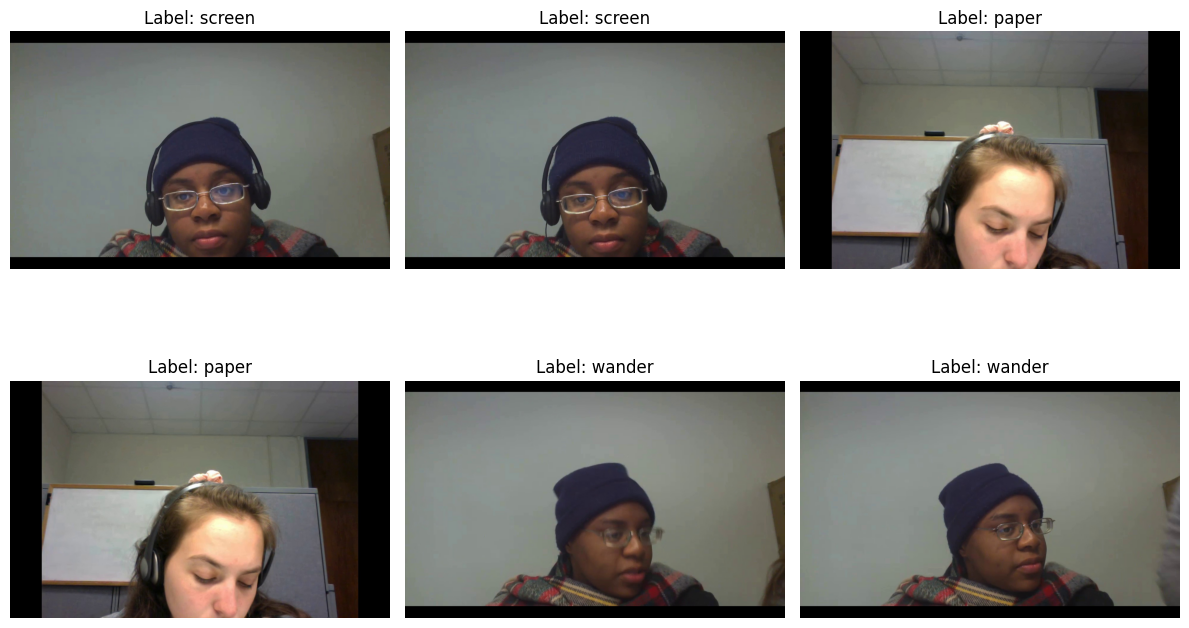

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_synthetic_dataset(dataset_path):
    images = []
    labels = []

    # Define the subdirectories and their corresponding labels
    subdirs_labels = {
        'paper_40': 'paper',
        'screen_40': 'screen',
        'wander_40': 'wander'
    }

    for subdir, label in subdirs_labels.items():
        subdir_path = os.path.join(dataset_path, subdir)

        if not os.path.exists(subdir_path):
            print(f"Warning: Directory {subdir_path} does not exist")
            continue

        # Get all jpg files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')]

        print(f"Loading {len(image_files)} images from {subdir} with label '{label}'")

        for image_file in sorted(image_files):
            image_path = os.path.join(subdir_path, image_file)

            try:
                # Load image using OpenCV
                image = cv2.imread(image_path)
                if image is not None:
                    # Convert from BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Warning: Could not load image {image_path}")
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    print(f"Total images loaded: {len(images)}")
    print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")

    return images, labels

# Load the synthetic dataset
dataset_path = "Synthetic_Dataset"
images, labels = load_synthetic_dataset(dataset_path)

# Display some sample images
def display_sample_images(images, labels, num_samples=6):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    # Get unique labels and their indices
    unique_labels = list(set(labels))
    samples_per_label = num_samples // len(unique_labels)

    sample_indices = []
    for label in unique_labels:
        label_indices = [i for i, l in enumerate(labels) if l == label]
        sample_indices.extend(label_indices[:samples_per_label])

    for i, idx in enumerate(sample_indices[:num_samples]):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
print("\nDisplaying sample images from the dataset:")
display_sample_images(images, labels)

# Load the dataset for resnet training

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image for transforms
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Encode string labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(f'Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}')

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')

# Create datasets
train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
val_dataset = ImageDataset(X_val, y_val, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')

# Load ResNet18 model
num_classes = len(label_encoder.classes_)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

print(f'ResNet18 model loaded with {num_classes} output classes')
print(f'Model architecture:')
print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Label mapping: {np.str_('paper'): 0, np.str_('screen'): 1, np.str_('wander'): 2}
Training set size: 96
Validation set size: 24
Number of training batches: 3
Number of validation batches: 1
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 212MB/s]

ResNet18 model loaded with 3 output classes
Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# Train and evaluate the model

Using device: cuda
Starting ResNet18 training...
Epoch [1/20], Batch [0/3], Loss: 1.1468
Epoch [1/20], Batch [2/3], Loss: 0.8974
Epoch [1/20] - Train Loss: 1.0408, Train Acc: 63.54%, Val Loss: 0.4037, Val Acc: 87.50%
Epoch [2/20], Batch [0/3], Loss: 0.1665
Epoch [2/20], Batch [2/3], Loss: 0.3860
Epoch [2/20] - Train Loss: 0.2734, Train Acc: 93.75%, Val Loss: 0.7399, Val Acc: 70.83%
Epoch [3/20], Batch [0/3], Loss: 0.3211
Epoch [3/20], Batch [2/3], Loss: 0.1145
Epoch [3/20] - Train Loss: 0.2745, Train Acc: 89.58%, Val Loss: 0.1226, Val Acc: 95.83%
Epoch [4/20], Batch [0/3], Loss: 0.1011
Epoch [4/20], Batch [2/3], Loss: 0.2208
Epoch [4/20] - Train Loss: 0.1427, Train Acc: 96.88%, Val Loss: 0.1212, Val Acc: 95.83%
Epoch [5/20], Batch [0/3], Loss: 0.1351
Epoch [5/20], Batch [2/3], Loss: 0.0662
Epoch [5/20] - Train Loss: 0.0785, Train Acc: 97.92%, Val Loss: 0.1517, Val Acc: 95.83%
Epoch [6/20], Batch [0/3], Loss: 0.0207
Epoch [6/20], Batch [2/3], Loss: 0.1245
Epoch [6/20] - Train Loss: 0.05

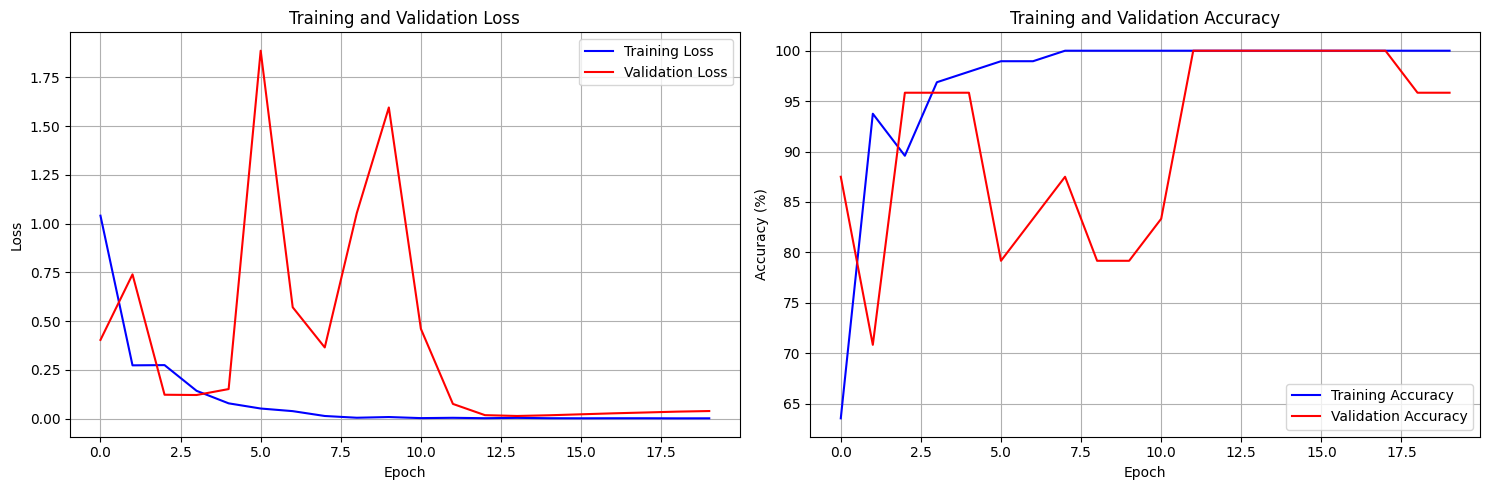

Final Validation Accuracy: 95.83%

Classification Report:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00         8
      screen       1.00      0.88      0.93         8
      wander       0.89      1.00      0.94         8

    accuracy                           0.96        24
   macro avg       0.96      0.96      0.96        24
weighted avg       0.96      0.96      0.96        24



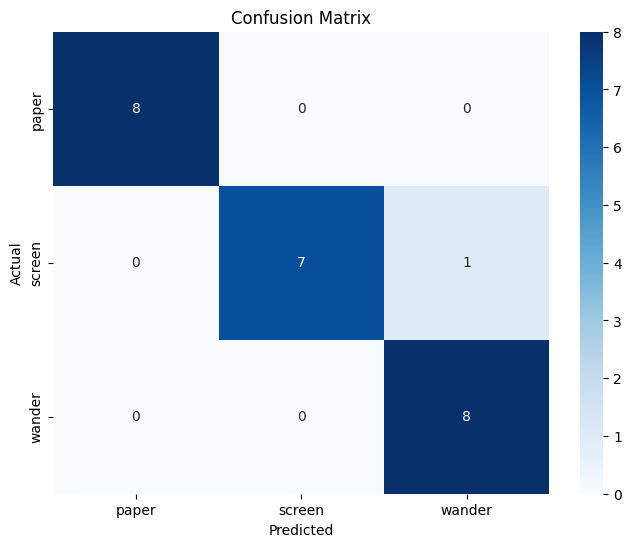


Testing sample predictions:


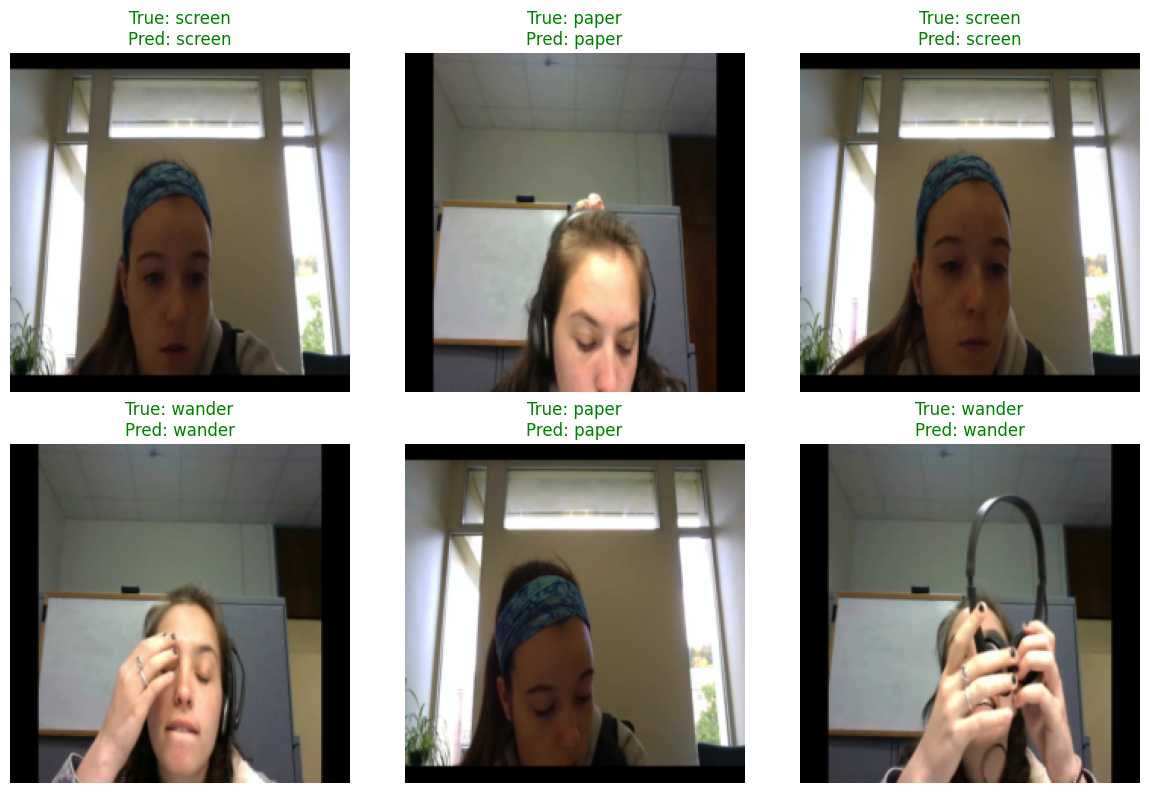

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

            if batch_idx % 2 == 0:  # Print every 2 batches
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate training accuracy
        train_acc = 100 * correct_train / total_train
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_acc = 100 * correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Update learning rate
        scheduler.step()

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Best validation accuracy: {best_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Start training
print("Starting ResNet18 training...")
import time
start_time = time.time()

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20
)

training_time = time.time() - start_time
print(f'Training completed in {training_time:.2f} seconds')

# Plot training progress
def plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_progress(train_losses, val_losses, train_accuracies, val_accuracies)

def evaluate_model(model, val_loader, label_encoder):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)
    print(f'Final Validation Accuracy: {accuracy:.2f}%')

    # Classification report
    class_names = label_encoder.classes_
    print('\nClassification Report:')
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return accuracy, all_predictions, all_targets

# Evaluate the model
final_accuracy, predictions, targets = evaluate_model(model, val_loader, label_encoder)

# Test on a few sample images
def test_sample_predictions(model, val_dataset, label_encoder, num_samples=6):
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    # Get random samples from validation set
    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = val_dataset[idx]
            image_batch = image.unsqueeze(0).to(device)

            output = model(image_batch)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

            # Convert back to original image for display
            image_display = image.permute(1, 2, 0).cpu().numpy()
            # Denormalize for display
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_display = std * image_display + mean
            image_display = np.clip(image_display, 0, 1)

            axes[i].imshow(image_display)
            true_class = label_encoder.inverse_transform([true_label])[0]
            pred_class = label_encoder.inverse_transform([predicted_label])[0]
            axes[i].set_title(f'True: {true_class}\nPred: {pred_class}',
                            color='green' if true_class == pred_class else 'red')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print('\nTesting sample predictions:')
test_sample_predictions(model, val_dataset, label_encoder)

# MIA

Loading MIA dataset (non-members)...
Loading 10 MIA images from paper_10 with label 'paper'
Loading 10 MIA images from screen_10 with label 'screen'
Loading 10 MIA images from wander_10 with label 'wander'
Total MIA images loaded: 30
MIA Label distribution: {np.str_('paper'): np.int64(10), np.str_('screen'): np.int64(10), np.str_('wander'): np.int64(10)}
Sampling members from trained dataset...
Sampled 30 member images from trained dataset
Member label distribution: {np.str_('paper'): np.int64(10), np.str_('screen'): np.int64(10), np.str_('wander'): np.int64(10)}

Creating MIA calibration set...
Calibration set: 15 members, 15 non-members
Calculating losses on calibration set...
Finding optimal threshold...
Best threshold: 2.9867, Calibration accuracy: 0.633

Creating MIA evaluation set...
Evaluation set: 15 members, 15 non-members
Calculating losses on evaluation set...

MIA Attack Results:
Calibration Accuracy: 0.633
Evaluation Accuracy: 0.633
Evaluation AUC: 0.564
Optimal Threshold:

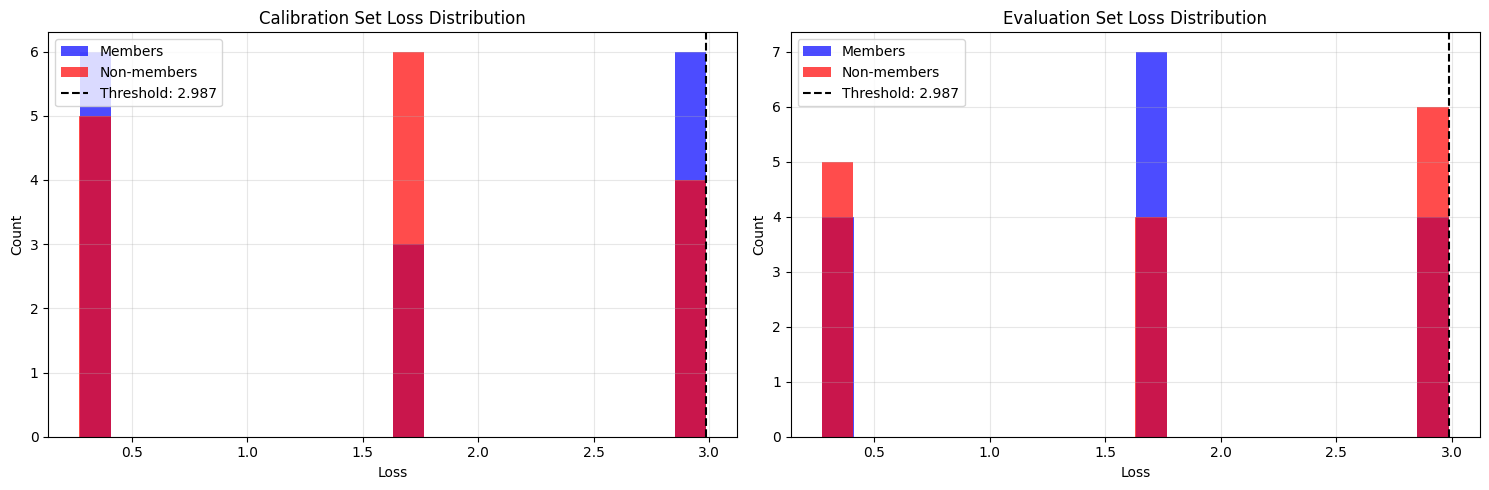


Detailed MIA Analysis:
Member examples (should have low loss):
  - Calibration: 1.6339
  - Evaluation: 1.6454
Non-member examples (should have high loss):
  - Calibration: 1.5542
  - Evaluation: 1.7303


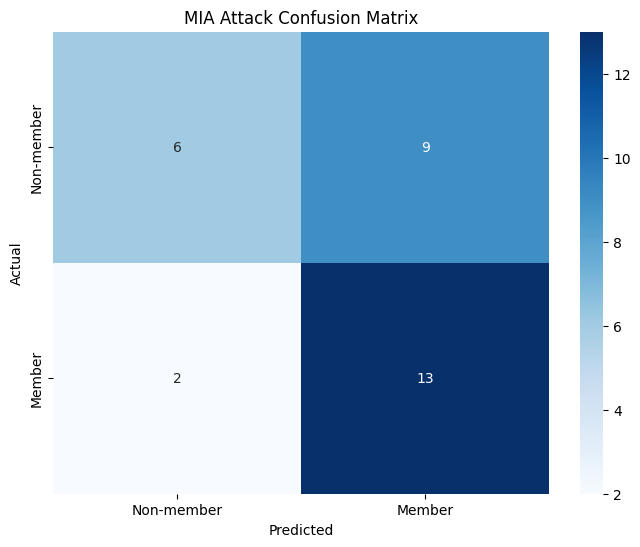


MIA Confusion Matrix:
True Negatives (correctly identified non-members): 6
False Positives (non-members predicted as members): 9
False Negatives (members predicted as non-members): 2
True Positives (correctly identified members): 13

Sample images from MIA dataset (non-members):


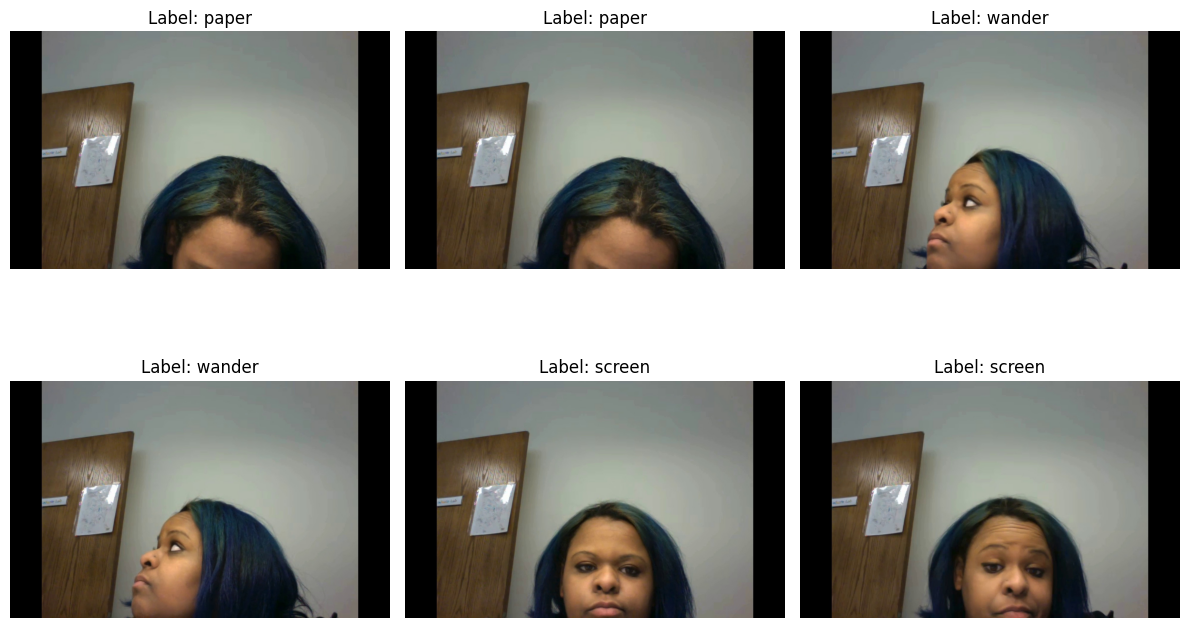


Sample images from member dataset:


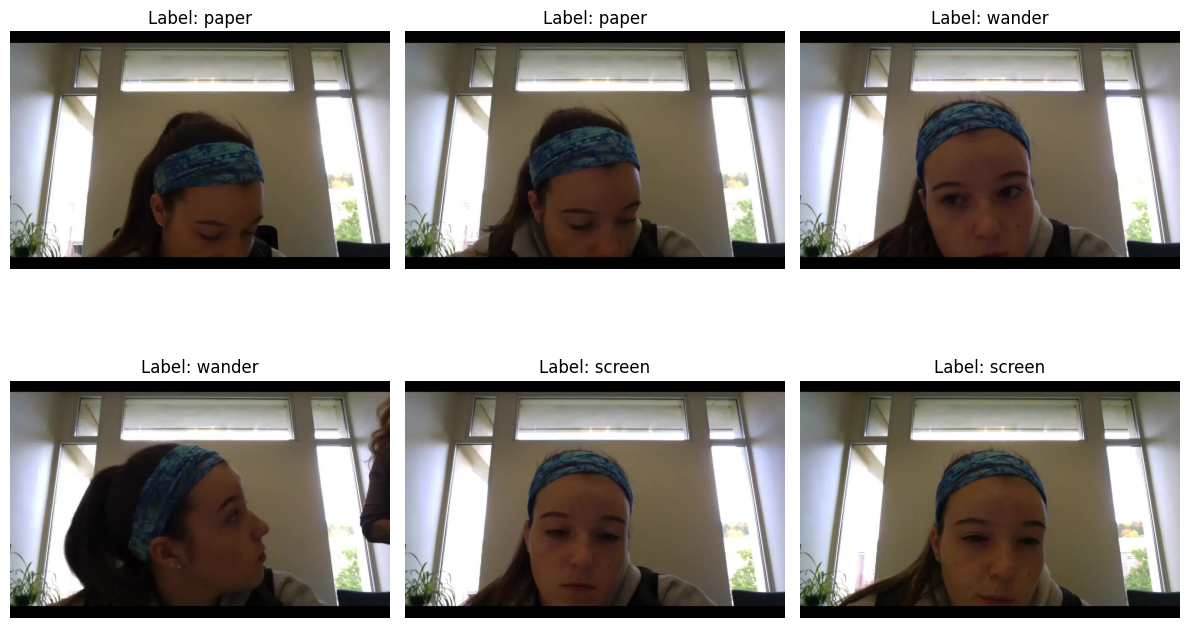

In [ ]:
# MIA Attack Implementation
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import random

def load_mia_dataset(dataset_path):
    images = []
    labels = []

    # Define the MIA subdirectories and their corresponding labels
    mia_subdirs_labels = {
        'MIA_paper_10': 'paper',
        'MIA_screen_10': 'screen',
        'MIA_wander_10': 'wander'
    }

    for subdir, label in mia_subdirs_labels.items():
        subdir_path = os.path.join(dataset_path, subdir)

        if not os.path.exists(subdir_path):
            print(f"Warning: Directory {subdir_path} does not exist")
            continue

        # Get all jpg files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')]

        print(f"Loading {len(image_files)} MIA images from {subdir} with label '{label}'")

        for image_file in sorted(image_files):
            image_path = os.path.join(subdir_path, image_file)

            try:
                # Load image using OpenCV
                image = cv2.imread(image_path)
                if image is not None:
                    # Convert from BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Warning: Could not load MIA image {image_path}")
            except Exception as e:
                print(f"Error loading MIA image {image_path}: {e}")

    print(f"Total MIA images loaded: {len(images)}")
    print(f"MIA Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")

    return images, labels

def sample_members_from_trained_data(images, labels, samples_per_class=10):
    """
    Sample members from the trained dataset (paper_40, screen_40, wander_40).
    These will be used as members (seen data).
    """
    member_images = []
    member_labels = []

    # Get unique classes
    unique_classes = np.unique(labels)

    for class_label in unique_classes:
        # Find indices for this class
        class_indices = [i for i, label in enumerate(labels) if label == class_label]

        # Sample specified number of images from this class
        sampled_indices = np.random.choice(class_indices, size=samples_per_class, replace=False)

        for idx in sampled_indices:
            member_images.append(images[idx])
            member_labels.append(labels[idx])

    print(f"Sampled {len(member_images)} member images from trained dataset")
    print(f"Member label distribution: {dict(zip(*np.unique(member_labels, return_counts=True)))}")

    return member_images, member_labels

def per_example_loss(model, images, labels, device):
    """
    Calculate per-example loss for a batch of images and labels.
    """
    model.eval()
    losses = []

    with torch.no_grad():
        for image, label in zip(images, labels):
            # Convert image to tensor and add batch dimension
            if isinstance(image, np.ndarray):
                image_tensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            else:
                image_tensor = image

            # Apply transforms
            image_tensor = val_transform(Image.fromarray(image_tensor.permute(1, 2, 0).numpy().astype(np.uint8)))
            image_tensor = image_tensor.unsqueeze(0).to(device)
            label_tensor = torch.tensor([label], device=device)

            # Get model output
            outputs = model(image_tensor)
            loss = F.cross_entropy(outputs, label_tensor, reduction='none')
            losses.append(loss.item())

    return np.array(losses)

# Load MIA dataset (non-members)
print("Loading MIA dataset (non-members)...")
mia_images, mia_labels = load_mia_dataset(dataset_path)

# Sample members from trained dataset
print("Sampling members from trained dataset...")
member_images, member_labels = sample_members_from_trained_data(images, labels, samples_per_class=10)

# Encode labels for both datasets
member_encoded_labels = label_encoder.transform(member_labels)
mia_encoded_labels = label_encoder.transform(mia_labels)

# Create calibration set (50% members, 50% non-members)
print("\nCreating MIA calibration set...")
n_cal_members = 15  # Use 15 members for calibration
n_cal_non_members = 15  # Use 15 non-members for calibration

cal_member_indices = random.sample(range(len(member_images)), n_cal_members)
cal_non_member_indices = random.sample(range(len(mia_images)), n_cal_non_members)

cal_images = [member_images[i] for i in cal_member_indices] + [mia_images[i] for i in cal_non_member_indices]
cal_labels = [member_encoded_labels[i] for i in cal_member_indices] + [mia_encoded_labels[i] for i in cal_non_member_indices]
cal_membership = [1] * n_cal_members + [0] * n_cal_non_members

print(f"Calibration set: {n_cal_members} members, {n_cal_non_members} non-members")

# Calculate losses on calibration set
print("Calculating losses on calibration set...")
cal_losses = per_example_loss(model, cal_images, cal_labels, device)

# Find optimal threshold
print("Finding optimal threshold...")
thresholds = np.percentile(cal_losses, np.linspace(1, 99, 99))
best_threshold = None
best_accuracy = -1

for threshold in thresholds:
    predictions = (cal_losses < threshold).astype(int)
    accuracy = (predictions == np.array(cal_membership)).mean()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.4f}, Calibration accuracy: {best_accuracy:.3f}")

# Create evaluation set (remaining data)
print("\nCreating MIA evaluation set...")
eval_member_indices = [i for i in range(len(member_images)) if i not in cal_member_indices]
eval_non_member_indices = [i for i in range(len(mia_images)) if i not in cal_non_member_indices]

# Use remaining members and non-members for evaluation
eval_images = [member_images[i] for i in eval_member_indices] + [mia_images[i] for i in eval_non_member_indices]
eval_labels = [member_encoded_labels[i] for i in eval_member_indices] + [mia_encoded_labels[i] for i in eval_non_member_indices]
eval_membership = [1] * len(eval_member_indices) + [0] * len(eval_non_member_indices)

print(f"Evaluation set: {len(eval_member_indices)} members, {len(eval_non_member_indices)} non-members")

# Calculate losses on evaluation set
print("Calculating losses on evaluation set...")
eval_losses = per_example_loss(model, eval_images, eval_labels, device)

# Apply threshold to evaluation set
eval_predictions = (eval_losses < best_threshold).astype(int)
eval_accuracy = (eval_predictions == np.array(eval_membership)).mean()
eval_auc = roc_auc_score(eval_membership, -eval_losses)  # smaller loss = more likely member

print(f"\nMIA Attack Results:")
print(f"Calibration Accuracy: {best_accuracy:.3f}")
print(f"Evaluation Accuracy: {eval_accuracy:.3f}")
print(f"Evaluation AUC: {eval_auc:.3f}")
print(f"Optimal Threshold: {best_threshold:.4f}")

# Visualize the results
def plot_mia_results(cal_losses, cal_membership, eval_losses, eval_membership, threshold):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot calibration losses
    member_losses = [cal_losses[i] for i in range(len(cal_losses)) if cal_membership[i] == 1]
    non_member_losses = [cal_losses[i] for i in range(len(cal_losses)) if cal_membership[i] == 0]

    ax1.hist(member_losses, alpha=0.7, label='Members', bins=20, color='blue')
    ax1.hist(non_member_losses, alpha=0.7, label='Non-members', bins=20, color='red')
    ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.3f}')
    ax1.set_xlabel('Loss')
    ax1.set_ylabel('Count')
    ax1.set_title('Calibration Set Loss Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot evaluation losses
    eval_member_losses = [eval_losses[i] for i in range(len(eval_losses)) if eval_membership[i] == 1]
    eval_non_member_losses = [eval_losses[i] for i in range(len(eval_losses)) if eval_membership[i] == 0]

    ax2.hist(eval_member_losses, alpha=0.7, label='Members', bins=20, color='blue')
    ax2.hist(eval_non_member_losses, alpha=0.7, label='Non-members', bins=20, color='red')
    ax2.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.3f}')
    ax2.set_xlabel('Loss')
    ax2.set_ylabel('Count')
    ax2.set_title('Evaluation Set Loss Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_mia_results(cal_losses, cal_membership, eval_losses, eval_membership, best_threshold)

# Detailed analysis
print(f"\nDetailed MIA Analysis:")
print(f"Member examples (should have low loss):")
print(f"  - Calibration: {np.mean([cal_losses[i] for i in range(len(cal_losses)) if cal_membership[i] == 1]):.4f}")
print(f"  - Evaluation: {np.mean([eval_losses[i] for i in range(len(eval_losses)) if eval_membership[i] == 1]):.4f}")

print(f"Non-member examples (should have high loss):")
print(f"  - Calibration: {np.mean([cal_losses[i] for i in range(len(cal_losses)) if cal_membership[i] == 0]):.4f}")
print(f"  - Evaluation: {np.mean([eval_losses[i] for i in range(len(eval_losses)) if eval_membership[i] == 0]):.4f}")

# Confusion matrix for MIA
mia_cm = confusion_matrix(eval_membership, eval_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(mia_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-member', 'Member'], yticklabels=['Non-member', 'Member'])
plt.title('MIA Attack Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"\nMIA Confusion Matrix:")
print(f"True Negatives (correctly identified non-members): {mia_cm[0,0]}")
print(f"False Positives (non-members predicted as members): {mia_cm[0,1]}")
print(f"False Negatives (members predicted as non-members): {mia_cm[1,0]}")
print(f"True Positives (correctly identified members): {mia_cm[1,1]}")

# Display sample images from both sets
print("\nSample images from MIA dataset (non-members):")
display_sample_images(mia_images, mia_labels, num_samples=6)

print("\nSample images from member dataset:")
display_sample_images(member_images, member_labels, num_samples=6)